<a href="https://colab.research.google.com/github/ainkun/DLSCA_test/blob/main/DLSCA_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import os
import sys
import h5py
import numpy as np
import random
from tqdm import tqdm

def check_file_exists(file_path):
	if os.path.exists(file_path) == False:
		print("Error: provided file path '%s' does not exist!" % file_path)
		sys.exit(-1)
	return

# The AES SBox that we will use to generate our labels
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

# G auxiliary function that is used to generate the permution of indices
G = np.array([0x0C, 0x05, 0x06, 0x0b, 0x09, 0x00, 0x0a, 0x0d, 0x03, 0x0e, 0x0f, 0x08, 0x04, 0x07, 0x01, 0x02])

# The permution function on the 16 indices i. The function is defined from the masks m0, m1, m2, and m3.
def permIndices(i,m0,m1,m2,m3):
	x0,x1,x2,x3 = m0&0x0f, m1&0x0f, m2&0x0f, m3&0x0f
	return G[G[G[G[(15-i)^x0]^x1]^x2]^x3]

# Two Tables to process a field multplication over GF(256): a*b = alog (log(a) + log(b) mod 255)
log_table=[ 0, 0, 25, 1, 50, 2, 26, 198, 75, 199, 27, 104, 51, 238, 223, 3,
	100, 4, 224, 14, 52, 141, 129, 239, 76, 113, 8, 200, 248, 105, 28, 193,
	125, 194, 29, 181, 249, 185, 39, 106, 77, 228, 166, 114, 154, 201, 9, 120,
	101, 47, 138, 5, 33, 15, 225, 36, 18, 240, 130, 69, 53, 147, 218, 142,
	150, 143, 219, 189, 54, 208, 206, 148, 19, 92, 210, 241, 64, 70, 131, 56,
	102, 221, 253, 48, 191, 6, 139, 98, 179, 37, 226, 152, 34, 136, 145, 16,
	126, 110, 72, 195, 163, 182, 30, 66, 58, 107, 40, 84, 250, 133, 61, 186,
	43, 121, 10, 21, 155, 159, 94, 202, 78, 212, 172, 229, 243, 115, 167, 87,
	175, 88, 168, 80, 244, 234, 214, 116, 79, 174, 233, 213, 231, 230, 173, 232,
	44, 215, 117, 122, 235, 22, 11, 245, 89, 203, 95, 176, 156, 169, 81, 160,
	127, 12, 246, 111, 23, 196, 73, 236, 216, 67, 31, 45, 164, 118, 123, 183,
	204, 187, 62, 90, 251, 96, 177, 134, 59, 82, 161, 108, 170, 85, 41, 157,
	151, 178, 135, 144, 97, 190, 220, 252, 188, 149, 207, 205, 55, 63, 91, 209,
	83, 57, 132, 60, 65, 162, 109, 71, 20, 42, 158, 93, 86, 242, 211, 171,
	68, 17, 146, 217, 35, 32, 46, 137, 180, 124, 184, 38, 119, 153, 227, 165,
	103, 74, 237, 222, 197, 49, 254, 24, 13, 99, 140, 128, 192, 247, 112, 7 ]

alog_table =[1, 3, 5, 15, 17, 51, 85, 255, 26, 46, 114, 150, 161, 248, 19, 53,
	95, 225, 56, 72, 216, 115, 149, 164, 247, 2, 6, 10, 30, 34, 102, 170,
	229, 52, 92, 228, 55, 89, 235, 38, 106, 190, 217, 112, 144, 171, 230, 49,
	83, 245, 4, 12, 20, 60, 68, 204, 79, 209, 104, 184, 211, 110, 178, 205,
	76, 212, 103, 169, 224, 59, 77, 215, 98, 166, 241, 8, 24, 40, 120, 136,
	131, 158, 185, 208, 107, 189, 220, 127, 129, 152, 179, 206, 73, 219, 118, 154,
	181, 196, 87, 249, 16, 48, 80, 240, 11, 29, 39, 105, 187, 214, 97, 163,
	254, 25, 43, 125, 135, 146, 173, 236, 47, 113, 147, 174, 233, 32, 96, 160,
	251, 22, 58, 78, 210, 109, 183, 194, 93, 231, 50, 86, 250, 21, 63, 65,
	195, 94, 226, 61, 71, 201, 64, 192, 91, 237, 44, 116, 156, 191, 218, 117,
	159, 186, 213, 100, 172, 239, 42, 126, 130, 157, 188, 223, 122, 142, 137, 128,
	155, 182, 193, 88, 232, 35, 101, 175, 234, 37, 111, 177, 200, 67, 197, 84,
	252, 31, 33, 99, 165, 244, 7, 9, 27, 45, 119, 153, 176, 203, 70, 202,
	69, 207, 74, 222, 121, 139, 134, 145, 168, 227, 62, 66, 198, 81, 243, 14,
	18, 54, 90, 238, 41, 123, 141, 140, 143, 138, 133, 148, 167, 242, 13, 23,
	57, 75, 221, 124, 132, 151, 162, 253, 28, 36, 108, 180, 199, 82, 246, 1 ]

# Multiplication function in GF(2^8)
def multGF256(a,b):
	if (a==0) or (b==0):
		return 0
	else:
		return alog_table[(log_table[a]+log_table[b]) %255]


# The single labelization function used for ASCADv1:
# It is as simple as the computation of the result of Sbox(p[2] + k[2]) (see the White Paper)
# Note: you can of course adapt the labelization here (say if you want to attack the first byte Sbox(p[0] + k[0])
# or if you want to attack another round of the algorithm).
def labelize(plaintexts, keys):
	return np.uint8(AES_Sbox[plaintexts[:, 2] ^ keys[:, 2]])

# The multi labelization function used for ASCADv2:
# It computes :
#	- the multiplative mask value alpha which correpond to r_m
#	- the additive mask value beta wich correspnd to rout
#	- the result of maskedSbox(p[i]^k[i]) for each i in [0..15]
#	- the result of maskedSbox(p[permInd[i]]^k[permInd[i]]) for each i in [0..15]
#	- the permuted indice value permInd[i] for each i in [0..15]
def multilabelize(metadata):
	def mult_sbox_mask_f(data, target_byte):
		ind = permIndices(target_byte,data["masks"][0],data["masks"][1],data["masks"][2],data["masks"][3])
		alpha = data["masks"][18]
		beta = data["masks"][17]
		S = AES_Sbox[data["plaintext"][ind]^data["key"][ind]]
		return multGF256(alpha,S)^beta

	def mult_sbox_mask_with_perm_f(data, target_byte):
		alpha = data["masks"][18]
		beta = data["masks"][17]
		S = AES_Sbox[data["plaintext"][target_byte]^data["key"][target_byte]]
		return multGF256(alpha,S)^beta

	def permind_f(data, target_byte):
		ind = permIndices(target_byte,data["masks"][0],data["masks"][1],data["masks"][2],data["masks"][3])
		return ind

	def alpha_mask_f(data):
		alpha = data["masks"][18]
		return alpha

	def beta_mask_f(data):
		beta = data["masks"][17]
		return beta

	y_alpha = np.array([alpha_mask_f(d) for d in metadata])
	y_beta = np.array([beta_mask_f(d) for d in metadata])
	y_sbox = []
	y_sbox_with_perm = []
	y_permind = []
	for i in range(16):
		y_sbox.append(np.array([mult_sbox_mask_f(d, i) for d in metadata]))
		y_sbox_with_perm.append(np.array([mult_sbox_mask_with_perm_f(d, i) for d in metadata]))
		y_permind.append(np.array([permind_f(d, i) for d in metadata]))
	y_sbox = np.transpose(y_sbox)
	y_sbox_with_perm = np.transpose(y_sbox_with_perm)
	y_permind = np.transpose(y_permind)
	multilabel_type = np.dtype([("alpha_mask", np.uint8, (1,)),
				  ("beta_mask", np.uint8, (1,)),
				  ("sbox_masked", np.uint8, (16,)),
				 ("sbox_masked_with_perm", np.uint8, (16,)),
				  ("perm_index", np.uint8, (16,))])
	multilabel = np.array([(y_alpha[n], y_beta[n], y_sbox[n], y_sbox_with_perm[n], y_permind[n]) for n in range(len(metadata))],  dtype=multilabel_type)
	return multilabel

# TODO: sanity checks on the parameters
# This function extract the POIs of the traces contained in a single file and labelized them.
def extract_traces(traces_file, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync=0, attack_desync=0, multilabel=0):
	print("Begin extraction")
	traces_file = os.path.normpath(traces_file)
	check_file_exists(traces_file)
	check_file_exists(os.path.dirname(labeled_traces_file))
	# Open the raw traces HDF5 for reading
	try:
		in_file	 = h5py.File(traces_file, "r")
	except:
		print("Error2: can't open HDF5 file '%s' for reading (it might be malformed) ..." % traces_file)
		sys.exit(-1)

	raw_traces = in_file['traces']
	raw_data = in_file['metadata']

	raw_plaintexts = raw_data['plaintext']
	raw_keys = raw_data['key']
	raw_masks = raw_data['masks']

	#TODO: deal with the case where "ciphertext" entry is there
	# Extract a larger set of points to handle desynchronization
	min_target_point = min(target_points)
	max_target_point = max(target_points)

	target_points = np.array(target_points)
	#we look for consecutive values in the target points, which would allow for a huge speed increase in the extraction
	diff = np.ediff1d(target_points)
	consecutive_indices = np.split(target_points,np.where(diff !=1)[0]+1)

	#######################################
	print("Processing profiling traces...")
	#######################################
	raw_traces_profiling = np.zeros([len(profiling_index), len(target_points)], raw_traces.dtype)
	profiling_desync_metadata = np.zeros(len(profiling_index), np.uint32)
	curr_trace = 0
	for trace in tqdm(profiling_index):
		if attack_desync !=0 or profiling_desync !=0:
			r_desync = random.randint(0, profiling_desync)
		else:
			r_desync = 0
		profiling_desync_metadata[curr_trace] = r_desync
		curr_point = 0
		for cons_chunk in consecutive_indices:
			raw_traces_profiling[curr_trace,curr_point:curr_point+len(cons_chunk)] = raw_traces[trace,cons_chunk[0]+r_desync:cons_chunk[len(cons_chunk)-1]+r_desync+1]
			curr_point += len(cons_chunk)
		curr_trace += 1

	####################################
	print("Processing attack traces...")
	####################################
	raw_traces_attack = np.zeros([len(attack_index), len(target_points)], raw_traces.dtype)
	attack_desync_metadata = np.zeros(len(attack_index))
	curr_trace = 0
	for trace in tqdm(attack_index):
		if attack_desync !=0 or profiling_desync !=0:
			r_desync = random.randint(0,attack_desync)
		else:
			r_desync = 0
		attack_desync_metadata[curr_trace] = r_desync
		curr_point = 0
		for cons_chunk in consecutive_indices:
			raw_traces_attack[curr_trace, curr_point:curr_point+len(cons_chunk)] = raw_traces[trace, cons_chunk[0]+r_desync:cons_chunk[len(cons_chunk)-1]+r_desync+1]
			curr_point += len(cons_chunk)
		curr_trace += 1

	############################
	print("Computing labels...")
	############################
	# Compute our labels
	if multilabel == 1:
		labels_profiling = multilabelize(raw_data[profiling_index])
		labels_attack  = multilabelize(raw_data[attack_index])
	else:
		labels_profiling = labelize(raw_plaintexts[profiling_index], raw_keys[profiling_index])
		labels_attack  = labelize(raw_plaintexts[attack_index], raw_keys[attack_index])

	print("Creating output_file...")
	# Open the output labeled file for writing
	try:
		out_file = h5py.File(labeled_traces_file, "w")
	except:
		print("Error3: can't open HDF5 file '%s' for writing ..." % labeled_traces_file)
		sys.exit(-1)
	# Create our HDF5 hierarchy in the output file:
	#	- Profilinging traces with their labels
	#	- Attack traces with their labels
	profiling_traces_group = out_file.create_group("Profiling_traces")
	attack_traces_group = out_file.create_group("Attack_traces")
	# Datasets in the groups
	profiling_traces_group.create_dataset(name="traces", data=raw_traces_profiling, dtype=raw_traces_profiling.dtype)
	attack_traces_group.create_dataset(name="traces", data=raw_traces_attack, dtype=raw_traces_attack.dtype)
	# Labels in the groups
	profiling_traces_group.create_dataset(name="labels", data=labels_profiling, dtype=labels_profiling.dtype)
	attack_traces_group.create_dataset(name="labels", data=labels_attack, dtype=labels_attack.dtype)
	#TODO: deal with the case where "ciphertext" entry is there
	# Put the metadata (plaintexts, keys, ...) so that one can check the key rank
	metadata_type = np.dtype([("plaintext", raw_plaintexts.dtype, (len(raw_plaintexts[0]),)),
				  ("key", raw_keys.dtype, (len(raw_keys[0]),)),
				  ("masks", raw_masks.dtype, (len(raw_masks[0]),)),
				  ("desync", np.uint32, (1,)),
				 ])
	profiling_metadata = np.array([(raw_plaintexts[n], raw_keys[n], raw_masks[n], profiling_desync_metadata[k]) for n, k  in zip(profiling_index, range(0, len(profiling_desync_metadata)))], dtype=metadata_type)
	profiling_traces_group.create_dataset("metadata", data=profiling_metadata, dtype=metadata_type)
	attack_metadata = np.array([(raw_plaintexts[n], raw_keys[n], raw_masks[n], attack_desync_metadata[k]) for n, k in zip(attack_index, range(0, len(attack_desync_metadata)))], dtype=metadata_type)
	attack_traces_group.create_dataset("metadata", data=attack_metadata, dtype=metadata_type)

	out_file.flush()
	out_file.close()
	in_file.close()

# This function concatenates two h5 groups f1_gp and f2_gp in a single group fout_gp. It assumes that the groups are formed of arrays of the same name.
# For each entry name k in f1_gp and f2_gp, an array that results in the concatenation of the arrays f1_gp[k] and f2_gp[k] is created in fout_gp.
# The arrays are concatenated along their first axis.
def h5_concatenate_group(f1_gp, f2_gp, fout_gp):
	keys = f1_gp.keys()
	dtypes = {}
	shapes = {}
	for k in keys:
		dtypes[k] = f1_gp[k].dtype
		shapes[k] = (f1_gp[k].shape[0] + f2_gp[k].shape[0], ) + f1_gp[k].shape[1:]
	for k in keys:
		fout_gp.create_dataset(k, shapes[k], dtype=dtypes[k])
		for i in tqdm(range(shapes[k][0])):
			if i<f1_gp[k].shape[0]:
				fout_gp[k][i] = f1_gp[k][i]
			else:
				fout_gp[k][i] = f2_gp[k][i-f1_gp[k].shape[0]]

# This function concatenates the arrays contained in the h5 files file1 and file2, resulting in a ew h5 file fileout.
# The arrays are concatenated along their first axis.
def h5_concatenate_file(file1, file2, fileout):
	f1 = h5py.File(file1, "r")
	f2 = h5py.File(file2, "r")
	fout = h5py.File(fileout, "w")

	print("Concatenation Profiling_traces")
	fout_profile_gp = fout.create_group("Profiling_traces")
	h5_concatenate_group(f1["Profiling_traces"], f2["Profiling_traces"], fout_profile_gp)

	print("Concatenation Attack_traces")
	fout_attack_gp = fout.create_group("Attack_traces")
	h5_concatenate_group(f1["Attack_traces"], f2["Attack_traces"], fout_attack_gp)

	fout.flush()
	fout.close()
	f1.close()
	f2.close()

# This function concatenates a list of files.
def h5_concatenate_file_list(file_list, fileout):
	if (len(file_list)<2):
		print("Error: traces_file_list shall contain at least two files")
		sys.exit(-1)
	fileout_tmp= fileout+ ".tmp"
	fileout_bis_tmp= fileout+ "_bis.tmp"
	print("Concatenation 1/{}".format(len(file_list)-1))
	h5_concatenate_file(file_list[0], file_list[1], fileout_tmp)
	for i,file_i in enumerate(file_list[2:]):
		print("Concatenation {}/{}".format(i+2, len(file_list)-1))
		h5_concatenate_file(fileout_tmp, file_i, fileout_bis_tmp)
		os.rename(fileout_bis_tmp, fileout_tmp)
	os.rename(fileout_tmp, fileout)

# This function extracts the POIs of the traces contained in different h5 files and labelized them.
# A temporary labelized file is created for each file of the input list.
# Then the temporary labelized files are concatenated to form a single file.
def extract_multiple_files(traces_files_list, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync=0, attack_desync=0, multilabel=0):
	last_window_offset = 0
	labeled_traces_files_list = [labeled_traces_file + "_part_{}.tmp".format(i) for i in range(len(traces_files_list))]
	for i, traces_file_i in enumerate(traces_files_list):
		try:
			in_file_i	 = h5py.File(traces_file_i, "r")
		except:
			print("Error1: can't open HDF5 file '%s' for reading (it might be malformed) ..." % traces_file_i)
			sys.exit(-1)
		l = len(in_file_i['traces'])
		in_file_i.close()
		window_i = np.arange(last_window_offset, last_window_offset+l)
		labeled_traces_file_i = labeled_traces_files_list[i]
		profiling_intersect_index_i = np.intersect1d(profiling_index,window_i)
		profiling_index_i = [x-last_window_offset for x in profiling_intersect_index_i]
		attack_intersect_index_i = np.intersect1d(attack_index,window_i)
		attack_index_i = [x-last_window_offset for x in attack_intersect_index_i]
		print("Extraction of file {}".format(traces_file_i))
		extract_traces(traces_file_i, labeled_traces_file_i, profiling_index_i, attack_index_i, target_points, profiling_desync, attack_desync, multilabel)
		last_window_offset += l
	h5_concatenate_file_list(labeled_traces_files_list, labeled_traces_file)
	for labeled_traces_file in labeled_traces_files_list:
		os.remove(labeled_traces_file)


def read_parameters_file(param_filename):
	#read parameters for the extract_traces function from given filename
	#TODO: sanity checks on parameters
	param_file = open(param_filename,"r")

	#FIXME: replace eval() by ast.linear_eval()
	my_parameters= eval(param_file.read())

	files_splitted = 0
	traces_file = ""
	traces_files_list = []
	if ("files_splitted" in my_parameters):
		files_splitted = my_parameters["files_splitted"]
		if ("traces_files_list" not in my_parameters):
			print("Error: traces_files_list parameter must be defined when files_splitted option is activated ...")
			sys.exit(-1)
		traces_files_list = my_parameters["traces_files_list"]
	if ("traces_file" in my_parameters):
		traces_file = my_parameters["traces_file"]
	multilabel = 0
	if ("multilabel" in my_parameters):
		multilabel = my_parameters["multilabel"]
	labeled_traces_file = my_parameters["labeled_traces_file"]
	profiling_index = my_parameters["profiling_index"]
	attack_index = my_parameters["attack_index"]
	target_points = my_parameters["target_points"]
	profiling_desync = my_parameters["profiling_desync"]
	attack_desync = my_parameters["attack_desync"]

	param_file.close()

	return files_splitted, traces_file, traces_files_list, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync, attack_desync, multilabel


if __name__ == "__main__":
	if len(sys.argv)!=2:
		#default parameters values
		ascad_data_folder = "ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_data/"
		ascad_databases_folder = ascad_data_folder + "ASCAD_databases/"

		original_raw_traces_file = ascad_databases_folder + "ATMega8515_raw_traces.h5"

		profiling_index = [n for n in range(0, 50000)]
		attack_index = [n for n in range(50000, 60000)]
		target_points=[n for n in range(45400, 46100)]
		profiling_desync=0
		attack_desync=0
		extract_traces(original_raw_traces_file, ascad_databases_folder + "ASCAD.h5"		  , profiling_index, attack_index, target_points, profiling_desync=0, attack_desync=0)
		extract_traces(original_raw_traces_file, ascad_databases_folder + "ASCAD_desync50.h5" , profiling_index, attack_index, target_points, profiling_desync=0, attack_desync = 50)
		extract_traces(original_raw_traces_file, ascad_databases_folder + "ASCAD_desync100.h5", profiling_index, attack_index, target_points, profiling_desync=0, attack_desync = 100)

	else:
		#get parameters from user input
		files_splitted, traces_file, traces_files_list, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync, attack_desync, multilabel = read_parameters_file(sys.argv[1])

		#execute the extraction function
		if (files_splitted !=1 ):
			extract_traces(traces_file, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync, attack_desync, multilabel)
		else:
			extract_multiple_files(traces_files_list, labeled_traces_file, profiling_index, attack_index, target_points, profiling_desync, attack_desync, multilabel)

Begin extraction
Error: provided file path 'ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5' does not exist!


SystemExit: -1

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import os
print(os.system("dir"))

0


In [ ]:
tt

In [ ]:
!wget https://static.data.gouv.fr/resources/ascad-atmega-8515-variable-key/20190730-071646/atmega8515-raw-traces.h5


--2024-01-16 10:32:28--  https://static.data.gouv.fr/resources/ascad-atmega-8515-variable-key/20190730-071646/atmega8515-raw-traces.h5
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.93
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75265497280 (70G) [application/octet-stream]
Saving to: ‘atmega8515-raw-traces.h5’

atmega8515-raw-trac   2%[                    ]   2.00G  19.0MB/s    in 1m 43s  

2024-01-16 10:34:11 (20.0 MB/s) - Connection closed at byte 2153073864. Retrying.

--2024-01-16 10:34:12--  (try: 2)  https://static.data.gouv.fr/resources/ascad-atmega-8515-variable-key/20190730-071646/atmega8515-raw-traces.h5
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 75265497280 (70G), 73112423416 (68G) remaining [application/octet-stream]
Saving to: ‘atmega8515-raw-trac

In [ ]:
!head -10 /content/atmega8515-raw-traces.h5


�HDF

                   ���������X,�   ��������        `              �       �                        �       �      TREE   ����������������        0      (                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       HEAP    X       0       �              metadata        info    trace   traces         (                                                    �     �������� �    &  2   key         *                         plaintext          *                         mask        *                        

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame("/content/atmega8515-raw-traces.h5", columns=['profiling_index','attack_index','target_points','profiling_points','attack_desync','target_desync'])

ValueError: DataFrame constructor not properly called!

In [ ]:
df = pd.DataFrame(np.array(h5py.File('/content/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5')), columns=['profiling_index'])

In [ ]:
df.head()

,profiling_index
0,metadata
1,traces


from matplotlib import pyplot as plt
_df_1['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('profiling_index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('profiling_index')):
  _plot_series(series, series_name, i)
  fig.legend(title='profiling_index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['profiling_index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='index', y='profiling_index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
df

,profiling_index
0,metadata
1,traces


In [ ]:
!wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip

--2024-01-16 11:35:42--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip       48%[========>           ]   2.00G  20.2MB/s    in 1m 40s  

2024-01-16 11:37:22 (20.6 MB/s) - Connection closed at byte 2152542323. Retrying.

--2024-01-16 11:37:23--  (try: 2)  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 4435199469 (4.1G), 2282657146 (2.1G) remaining [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[+++++++++==========>]   4.13G  29.4MB/s    in 78s     

2024-01-16 11:38:42 (28.0 MB/s) - ‘ASCA

In [ ]:
data = pd.read_hdf('/content/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5')

ValueError: Dataset(s) incompatible with Pandas data types, not table, or no datasets found in HDF5 file.

In [ ]:
!unzip /content/ASCAD_data.zip


Archive:  /content/ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync100_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync50_epochs75_classes256_batchsize200.h5  
ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync50_epochs75_classes256_batchsize200.h5:  write error (disk full?).  Continue? (y/n/^C) 

In [ ]:
!ls /content/


sample_data


In [ ]:
!ip a


1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
7: eth0@if8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc noqueue state UP group default 
    link/ether 02:42:ac:1c:00:0c brd ff:ff:ff:ff:ff:ff link-netnsid 0
    inet 172.28.0.12/16 brd 172.28.255.255 scope global eth0
       valid_lft forever preferred_lft forever


In [ ]:
!uname -a



Linux 1c2228ea67d5 6.1.58+ #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
!wget https://github.com/andrew-d/static-binaries/raw/master/binaries/linux/x86_64/nping


--2024-01-17 17:16:31--  https://github.com/andrew-d/static-binaries/raw/master/binaries/linux/x86_64/nping
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-d/static-binaries/master/binaries/linux/x86_64/nping [following]
--2024-01-17 17:16:32--  https://raw.githubusercontent.com/andrew-d/static-binaries/master/binaries/linux/x86_64/nping
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3402256 (3.2M) [application/octet-stream]
Saving to: ‘nping’

nping               100%[===================>]   3.24M  --.-KB/s    in 0.09s   

2024-01-17 17:16:32 (37.1 MB/s) - ‘nping’ saved [3402256/3402256

In [ ]:
!ls


nping  sample_data


In [ ]:
!./nping

/bin/bash: line 1: ./nping: Permission denied


In [ ]:
!sudo -l

Matching Defaults entries for root on 1c2228ea67d5:
    env_reset, mail_badpass,
    secure_path=/usr/local/sbin\:/usr/local/bin\:/usr/sbin\:/usr/bin\:/sbin\:/bin\:/snap/bin,
    use_pty

User root may run the following commands on 1c2228ea67d5:
    (ALL : ALL) ALL


In [ ]:
!sudo whoami

root


In [ ]:
!sudo ./nping

sudo: ./nping: command not found


In [ ]:
!ls

nping  sample_data


In [ ]:
!file nping

nping: ELF 64-bit LSB executable, x86-64, version 1 (SYSV), statically linked, stripped


In [ ]:
!sudo ./nping

sudo: ./nping: command not found


In [ ]:
!git clone https://github.com/ANSSI-FR/ASCAD.git


Cloning into 'ASCAD'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 109 (delta 12), reused 9 (delta 9), pack-reused 88
Receiving objects: 100% (109/109), 178.25 KiB | 965.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!cd ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/

In [ ]:
!wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip

--2024-01-23 10:09:24--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[===================>]   4.13G  17.8MB/s    in 4m 0s   

2024-01-23 10:13:26 (17.6 MB/s) - ‘ASCAD_data.zip’ saved [4435199469/4435199469]



In [ ]:
!unzip ASCAD_data.zip

Archive:  ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync100_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync50_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync0_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync100_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best

In [ ]:
!ls

ASCAD  ASCAD_data  ASCAD_data.zip  sample_data


In [ ]:
#!python3 /content/ASCAD/ASCAD_generate.py /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_generate_params
!cp -r /content/ASCAD_data /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/

In [ ]:
!cd ASCAD && python3 /content/ASCAD/ASCAD_generate.py /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_generate_params

Begin extraction
Processing profiling traces...
100% 50000/50000 [00:20<00:00, 2447.04it/s]
Processing attack traces...
100% 10000/10000 [00:04<00:00, 2393.47it/s]
Computing labels...
Creating output_file...


In [ ]:
!cd ASCAD && python3 /content/ASCAD/ASCAD_train_models.py /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_train_models_params

2024-01-23 10:39:14.379948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:39:14.380014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:39:14.381495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:39:14.388939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 10:39:17.060214: I external/local_

In [ ]:
!cd ASCAD && python /content/ASCAD/ASCAD_test_models.py /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_test_models_params

no display found. Using non-interactive Agg backend
2024-01-23 10:33:17.485984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:33:17.486050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:33:17.487972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:33:17.498673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler 

In [ ]:
!pip install tensorflow


In [ ]:
!nano /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_test_models_params


/bin/bash: line 1: nano: command not found


In [ ]:
!cd ASCAD && python /content/ASCAD/ASCAD_test_models.py /content/ml_test_param

no display found. Using non-interactive Agg backend
2024-01-23 10:33:12.344208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:33:12.344262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:33:12.345699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:33:12.353296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler 

In [ ]:
!cd ASCAD && pwd

/content/ASCAD


In [ ]:
!pip install cuda-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 27.5 MB/s eta 0:00:00


In [ ]:
!cd ASCAD && python /content/ASCAD/ASCAD_test_models.py /content/ml_test_param

/bin/bash: line 1: cd: ASCAD: No such file or directory


In [ ]:
!python3 -m pip install --upgrade tensorrt


  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17283 sha256=f69086290f7543a900a79c7f45168e56c55f917154fa2a7900a0cd08277d70c2
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [ ]:
import tensorrt

In [ ]:
!sudo apt-get install tensorrt


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-cccl-12-1 cuda-cudart-12-1 cuda-cudart-dev-12-1 cuda-driver-dev-12-1
  cuda-nvcc-12-1 cuda-toolkit-12-1-config-common libnvinfer-bin libnvinfer-dev
  libnvinfer-dispatch-dev libnvinfer-dispatch8 libnvinfer-headers-dev
  libnvinfer-headers-plugin-dev libnvinfer-lean-dev libnvinfer-lean8
  libnvinfer-plugin-dev libnvinfer-plugin8 libnvinfer-samples
  libnvinfer-vc-plugin-dev libnvinfer-vc-plugin8 libnvinfer8
  libnvonnxparsers-dev libnvonnxparsers8 libnvparsers-dev libnvparsers8
The following NEW packages will be installed:
  cuda-cccl-12-1 cuda-cudart-12-1 cuda-cudart-dev-12-1 cuda-driver-dev-12-1
  cuda-nvcc-12-1 cuda-toolkit-12-1-config-common libnvinfer-bin libnvinfer-dev
  libnvinfer-dispatch-dev libnvinfer-dispatch8 libnvinfer-headers-dev
  libnvinfer-headers-plugin-dev libnvinfer-lean-dev libnvinfer-lean8
  libnvinfer-plugin-d

In [ ]:
!cd ASCAD && python /content/ASCAD/ASCAD_test_models.py /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_test_models_params

no display found. Using non-interactive Agg backend
2024-01-23 10:37:39.353544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:37:39.353621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:37:39.355834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:37:39.367239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler 

In [3]:
!git clone https://github.com/google/scaaml.git


Cloning into 'scaaml'...
remote: Enumerating objects: 1602, done.
remote: Counting objects: 100% (1602/1602), done.
remote: Compressing objects: 100% (682/682), done.
remote: Total 1602 (delta 1096), reused 1263 (delta 867), pack-reused 0
Receiving objects: 100% (1602/1602), 653.75 KiB | 8.72 MiB/s, done.
Resolving deltas: 100% (1096/1096), done.


In [4]:
!wget https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip

--2024-01-25 10:33:25--  https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8769223087 (8.2G) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]   8.17G   253MB/s    in 41s     

2024-01-25 10:34:06 (203 MB/s) - ‘datasets.zip’ saved [8769223087/8769223087]



In [6]:
!unzip /content/datasets.zip

Archive:  /content/datasets.zip
   creating: datasets/
   creating: datasets/tinyaes/
   creating: datasets/tinyaes/train/
  inflating: datasets/tinyaes/train/2c7ab9767ac64bc4634a357653cf3d34.npz  
  inflating: datasets/tinyaes/train/dbcaed04d4834a01ee61645de10cb054.npz  
  inflating: datasets/tinyaes/train/c592337d5dca7207627432c386d43268.npz  
  inflating: datasets/tinyaes/train/02446f05f3e514e1fe6f98cffc25e444.npz  
  inflating: datasets/tinyaes/train/0a157c22e7504915fa2161bf11b3866f.npz  
  inflating: datasets/tinyaes/train/eb0880e8fd4d01988b0a77dc9cd55e71.npz  
  inflating: datasets/tinyaes/train/1db7794c3232d45ed332e065330ad6d1.npz  
  inflating: datasets/tinyaes/train/6c69d5809cc8638806f5aed36589d1cc.npz  
  inflating: datasets/tinyaes/train/2b14bbfd1d72de5195b39f30cf073dc0.npz  
  inflating: datasets/tinyaes/train/d07aace23c7b96adbd640240d8a2424e.npz  
  inflating: datasets/tinyaes/train/5d2ade2c290954fb564d9489ad07558a.npz  
  inflating: datasets/tinyaes/train/b70d74224d07c1d7

In [7]:
!unzip models.zip

Archive:  models.zip
   creating: models/
   creating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/
   creating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/variables/
  inflating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/variables/variables.index  
  inflating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/variables/variables.data-00000-of-00002  
  inflating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/variables/variables.data-00001-of-00002  
   creating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/assets/
  inflating: models/stm32f415-tinyaes-cnn-v10-ap_key-byte_6-len_20000/saved_model.pb  
   creating: models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_9-len_20000/
   creating: models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_9-len_20000/variables/
  inflating: models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_9-len_20000/variables/variables.index  
  inflating: models/stm32f415-tinyaes-c

In [8]:
!mv datasets /content/scaaml/scaaml_intro/

In [9]:
!mv models /content/scaaml/scaaml_intro/

In [10]:
!pip install -r /content/scaaml/requirements.txt

In [11]:
!sudo apt install tensorrt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tensorrt is already the newest version (8.6.1.6-1+cuda12.0).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [15]:
!cd /content/scaaml && python3 /content/scaaml/setup.py install

/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:509: InformationOnly: Normalizing '2.0.1r1706179326' to '2.0.1.post1706179326'
  self.metadata.version = self._normalize_version(
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        **************************************************************

In [54]:
!cd /content/scaaml/scaaml_intro && python /content/scaaml/scaaml_intro/train.py -c /content/scaaml/scaaml_intro/config/stm32f415_tinyaes.json

2024-01-25 11:38:19.320765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:38:19.320820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:38:19.322310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
loading shards: 100% 10/10 [00:02<00:00,  3.47it/s]
[Generator]
|-attack point:sub_bytes_out
|-attack byte:0
|-num shards:10
|-traces per shards:256
|-y:(2560, 256)
|-x:(2560, 20000, 1)
loading shards: 100% 10/10 [00:02<00:00,  4.32it/s]
[Generator]
|-attack point:sub_bytes_out
|-attack byte:0
|-num shards:10
|-traces per shards:16
|-y:(160, 256)
|-x:(160, 20000,

In [46]:
from glob import glob

pattern = f"/content/scaaml/scaaml_intro/datasets/tinyaes/train*"
num_shards=256

def list_shards(file_pattern, num_shards):
    return glob(file_pattern)[:num_shards]


In [47]:
list_shards(pattern,num_shards)

['/content/scaaml/scaaml_intro/datasets/tinyaes/train']

In [55]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

In [57]:
target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("/content/scaaml/scaaml_intro/config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']

Physical devices cannot be modified after being initialized


In [58]:
available_models = get_models_by_attack_point(target_config)


Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16


In [59]:
DATASET_GLOB = "/content/scaaml/scaaml_intro/datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 10)

In [64]:
# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_out'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

# load model
print(available_models[ATTACK_POINT][ATTACK_BYTE])
model = load_model_from_disk("/content/scaaml/scaaml_intro/models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000")

models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000


In [65]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack


    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

Recovering bytes:   0%|          | 0/10 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 27ms/step


In [66]:
print("Accuracy: %.2f" % model_metrics['acc'].result())

Accuracy: 0.00


/usr/local/lib/python3.10/dist-packages/scaaml-2.0.1.post1706175617-py3.10.egg/scaaml/plot.py:151: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


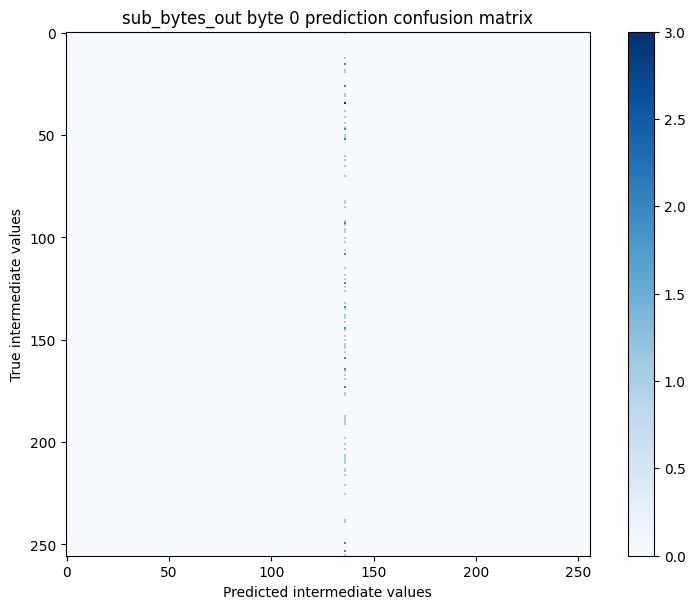

In [67]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


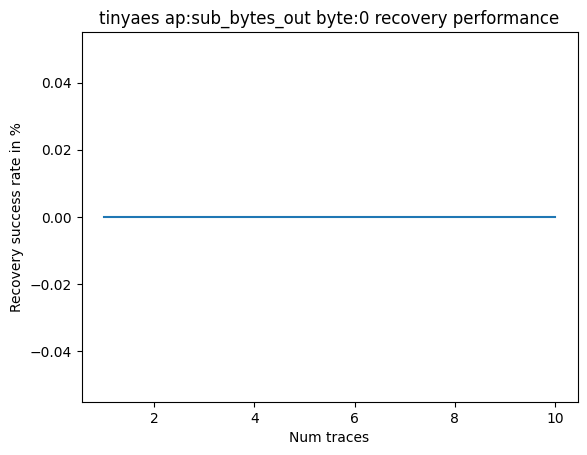

In [68]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()